# Project Overview
This project focuses on predicting delivery times using a machine learning approach. By analyzing a dataset of past deliveries, we aim to uncover patterns and factors that influence the time it takes to complete an order. Key tasks include:

1. Exploring the dataset and understanding the available variables.
2. Performing data cleaning and feature engineering to prepare the data for modeling.
3. Training a regression model to estimate delivery times based on factors such as order details, agent performance, and geolocation data.
4. Evaluating model performance and refining our approach for more accurate predictions.
5. Providing a clear, documented pipeline that can be reproduced and easily updated for future analysis.

The final goal is to produce a robust, data-driven tool that enables more precise delivery time estimates, supporting operational efficiency and improving the overall customer experience.

# Environment Preparation and Data Loading


In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


from geopy.distance import geodesic # used to calculate the distance between store points and drop points
from datetime import datetime, timedelta # used to change date into weekday
import re # used to check the format of the order_date


from sklearn.cluster import KMeans 

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
df=pd.read_csv("amazon_delivery.csv")
df

Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
0      ialx566343618         37           4.9       22.745049   
1      akqg208421122         34           4.5       12.913041   
2      njpu434582536         23           4.4       12.914264   
3      rjto796129700         38           4.7       11.003669   
4      zguw716275638         32           4.6       12.972793   
...              ...        ...           ...             ...   
43734  jlxf819993117         30           4.8       26.902328   
43735  aevx342135787         21           4.6        0.000000   
43736  xnek760674819         30           4.9       13.022394   
43737  cynl434665991         20           4.7       11.001753   
43738  nsyz997960170         23           4.9       23.351058   

       Store_Longitude  Drop_Latitude  Drop_Longitude  Order_Date Order_Time  \
0            75.892471      22.765049       75.912471  2022-03-19   11:30:00   
1            77.683237      13.043041       77.813237  2022-03-25   19:45:00   
2            77.678400      12.924264       77.688400  2022-03-19   08:30:00   
3            76.976494      11.053669       77.026494  2022-04-05   18:00:00   
4            80.249982      13.012793       80.289982  2022-03-26   13:30:00   
...                ...            ...             ...         ...        ...   
43734        75.794257      26.912328       75.804257  2022-03-24   11:35:00   
43735         0.000000       0.070000        0.070000  2022-02-16   19:55:00   
43736        80.242439      13.052394       80.272439  2022-03-11   23:50:00   
43737        76.986241      11.041753       77.026241  2022-03-07   13:35:00   
43738        85.325731      23.431058       85.405731  2022-03-02   17:10:00   

      Pickup_Time     Weather  Traffic      Vehicle            Area  \
0        11:45:00       Sunny    High   motorcycle           Urban    
1        19:50:00      Stormy     Jam      scooter   Metropolitian    
2        08:45:00  Sandstorms     Low   motorcycle           Urban    
3        18:10:00       Sunny  Medium   motorcycle   Metropolitian    
4        13:45:00      Cloudy    High      scooter   Metropolitian    
...           ...         ...      ...          ...             ...   
43734    11:45:00       Windy    High   motorcycle   Metropolitian    
43735    20:10:00       Windy     Jam   motorcycle   Metropolitian    
43736    00:05:00      Cloudy     Low      scooter   Metropolitian    
43737    13:40:00      Cloudy    High   motorcycle   Metropolitian    
43738    17:15:00         Fog  Medium      scooter   Metropolitian    

       Delivery_Time     Category  
0                120     Clothing  
1                165  Electronics  
2                130       Sports  
3                105    Cosmetics  
4                150         Toys  
...              ...          ...  
43734            160         Home  
43735            180      Jewelry  
43736             80         Home  
43737            130      Kitchen  
43738            180    Cosmetics  

[43739 rows x 16 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


In [5]:
# Check for unique values for each categorical column
print(df['Agent_Age'].unique())
print(df['Agent_Rating'].unique())
print(df['Weather'].unique())
print(df['Traffic'].unique())
print(df['Vehicle'].unique())
print(df['Area'].unique())
print(df['Category'].unique())

[37 34 23 38 32 22 33 35 36 21 24 29 25 31 27 26 20 28 39 30 15 50]
[4.9 4.5 4.4 4.7 4.6 4.8 4.2 4.3 4.  4.1 5.  3.5 3.8 nan 3.9 3.7 2.6 2.5
 3.6 3.1 2.7 1.  3.2 3.3 6.  3.4 2.8 2.9 3. ]
['Sunny' 'Stormy' 'Sandstorms' 'Cloudy' 'Fog' 'Windy' nan]
['High ' 'Jam ' 'Low ' 'Medium ' 'NaN ']
['motorcycle ' 'scooter ' 'van' 'bicycle ']
['Urban ' 'Metropolitian ' 'Semi-Urban ' 'Other']
['Clothing' 'Electronics' 'Sports' 'Cosmetics' 'Toys' 'Snacks' 'Shoes'
 'Apparel' 'Jewelry' 'Outdoors' 'Grocery' 'Books' 'Kitchen' 'Home'
 'Pet Supplies' 'Skincare']


# Date Cleaning
## Check for missing values

In [7]:
df_clean = df.replace('NaN ', np.nan)
df_clean.isnull().sum()

Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time         91
Pickup_Time         0
Weather            91
Traffic            91
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

In [8]:
# Because the three columns 'Order_Time', 'Weather', and 'Traffic' contain the same number of NANs, check if they are all the same rows.
nan_rows = df_clean[df_clean[['Order_Time', 'Weather', 'Traffic']].isnull().all(axis=1)]
print(nan_rows)

            Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
2286   xige084493792         15           1.0      -26.891191   
2779   oilg311747812         15           1.0       22.750040   
2825   pbox816153129         15           1.0       21.149569   
3438   nzsa056960624         50           6.0      -12.970324   
4514   eids248121351         50           6.0      -17.451976   
...              ...        ...           ...             ...   
40359  lasg907081524         50           6.0       22.751234   
41088  wgdm794380305         50           6.0      -12.939496   
42598  llox673359294         15           1.0        0.000000   
43053  ifig993965994         15           1.0       13.086438   
43490  vvkj353798064         50           6.0        0.000000   

       Store_Longitude  Drop_Latitude  Drop_Longitude  Order_Date Order_Time  \
2286         75.802083      26.981191       75.892083  2022-03-12        NaN   
2779         75.902847      22.810040       75.962847  2022

In [9]:
# Drop these 91 rows
df_clean = df_clean.dropna(subset=['Order_Time', 'Weather', 'Traffic'])
print(df_clean.shape) 
df_clean.isnull().sum()

(43648, 16)


Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather             0
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64

In [10]:
# check if the Agent_Rating is associated with the Agent_Age
age_rating_mean = df_clean.groupby('Agent_Age')['Agent_Rating'].median()
age_rating_mean 

Agent_Age
20    4.7
21    4.7
22    4.7
23    4.7
24    4.7
25    4.7
26    4.7
27    4.7
28    4.7
29    4.7
30    4.7
31    4.7
32    4.7
33    4.7
34    4.7
35    4.7
36    4.7
37    4.7
38    4.7
39    4.7
Name: Agent_Rating, dtype: float64

In [11]:
# As the Agent_age will not affect the Agent_ranking, fullfil the Agent_ranking with median
df_clean['Agent_Rating'].fillna(df_clean['Agent_Rating'].median(), inplace=True)
df_clean.isnull().sum()

Order_ID           0
Agent_Age          0
Agent_Rating       0
Store_Latitude     0
Store_Longitude    0
Drop_Latitude      0
Drop_Longitude     0
Order_Date         0
Order_Time         0
Pickup_Time        0
Weather            0
Traffic            0
Vehicle            0
Area               0
Delivery_Time      0
Category           0
dtype: int64

## Longitude and Latitude
- check the zeros in data
- calculate the distance between store and drop points

In [13]:
# check the zeros in locations
zero_counts = (df_clean == 0).sum()
print(zero_counts)

Order_ID              0
Agent_Age             0
Agent_Rating          0
Store_Latitude     3495
Store_Longitude    3495
Drop_Latitude         0
Drop_Longitude        0
Order_Date            0
Order_Time            0
Pickup_Time           0
Weather               0
Traffic               0
Vehicle               0
Area                  0
Delivery_Time         0
Category              0
dtype: int64


In [14]:
zeros_rows = df_clean[(df_clean['Store_Latitude']==0)|(df_clean['Store_Longitude']==0)][
    ['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude']
]
print(zeros_rows)


       Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude
33                0.0              0.0           0.11            0.11
51                0.0              0.0           0.03            0.03
56                0.0              0.0           0.08            0.08
58                0.0              0.0           0.06            0.06
66                0.0              0.0           0.02            0.02
...               ...              ...            ...             ...
43715             0.0              0.0           0.07            0.07
43722             0.0              0.0           0.13            0.13
43723             0.0              0.0           0.09            0.09
43725             0.0              0.0           0.05            0.05
43735             0.0              0.0           0.07            0.07

[3495 rows x 4 columns]


In [15]:
# Although the store locations are represented as zeros, the drop points vary. 
# These drop points can also be used to calculate the distance between the origin and destination.
# Calculate the Haverine Distance
def calculate_distance(row):
    start = (row['Store_Latitude'], row['Store_Longitude'])  # (0,0)
    end = (row['Drop_Latitude'], row['Drop_Longitude'])
    return geodesic(start, end).kilometers

df_clean['Disatance_km']=df_clean.apply(calculate_distance,axis=1)
df_clean

Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
0      ialx566343618         37           4.9       22.745049   
1      akqg208421122         34           4.5       12.913041   
2      njpu434582536         23           4.4       12.914264   
3      rjto796129700         38           4.7       11.003669   
4      zguw716275638         32           4.6       12.972793   
...              ...        ...           ...             ...   
43734  jlxf819993117         30           4.8       26.902328   
43735  aevx342135787         21           4.6        0.000000   
43736  xnek760674819         30           4.9       13.022394   
43737  cynl434665991         20           4.7       11.001753   
43738  nsyz997960170         23           4.9       23.351058   

       Store_Longitude  Drop_Latitude  Drop_Longitude  Order_Date Order_Time  \
0            75.892471      22.765049       75.912471  2022-03-19   11:30:00   
1            77.683237      13.043041       77.813237  2022-03-25   19:45:00   
2            77.678400      12.924264       77.688400  2022-03-19   08:30:00   
3            76.976494      11.053669       77.026494  2022-04-05   18:00:00   
4            80.249982      13.012793       80.289982  2022-03-26   13:30:00   
...                ...            ...             ...         ...        ...   
43734        75.794257      26.912328       75.804257  2022-03-24   11:35:00   
43735         0.000000       0.070000        0.070000  2022-02-16   19:55:00   
43736        80.242439      13.052394       80.272439  2022-03-11   23:50:00   
43737        76.986241      11.041753       77.026241  2022-03-07   13:35:00   
43738        85.325731      23.431058       85.405731  2022-03-02   17:10:00   

      Pickup_Time     Weather  Traffic      Vehicle            Area  \
0        11:45:00       Sunny    High   motorcycle           Urban    
1        19:50:00      Stormy     Jam      scooter   Metropolitian    
2        08:45:00  Sandstorms     Low   motorcycle           Urban    
3        18:10:00       Sunny  Medium   motorcycle   Metropolitian    
4        13:45:00      Cloudy    High      scooter   Metropolitian    
...           ...         ...      ...          ...             ...   
43734    11:45:00       Windy    High   motorcycle   Metropolitian    
43735    20:10:00       Windy     Jam   motorcycle   Metropolitian    
43736    00:05:00      Cloudy     Low      scooter   Metropolitian    
43737    13:40:00      Cloudy    High   motorcycle   Metropolitian    
43738    17:15:00         Fog  Medium      scooter   Metropolitian    

       Delivery_Time     Category  Disatance_km  
0                120     Clothing      3.020737  
1                165  Electronics     20.143737  
2                130       Sports      1.549693  
3                105    Cosmetics      7.774497  
4                150         Toys      6.197898  
...              ...          ...           ...  
43734            160         Home      1.488112  
43735            180      Jewelry     10.983242  
43736             80         Home      4.648024  
43737            130      Kitchen      6.219668  
43738            180    Cosmetics     12.057294  

[43648 rows x 17 columns]

## Data encoding
- Label Encoding: Traffic


In [17]:
# Traffic (Label Encoding）
category_map = {'Low ': 0, 'Medium ':1, 'High ': 2,'Jam ':3}
df_clean['Traffic_code'] = df_clean['Traffic'].map(category_map)
df_clean

Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
0      ialx566343618         37           4.9       22.745049   
1      akqg208421122         34           4.5       12.913041   
2      njpu434582536         23           4.4       12.914264   
3      rjto796129700         38           4.7       11.003669   
4      zguw716275638         32           4.6       12.972793   
...              ...        ...           ...             ...   
43734  jlxf819993117         30           4.8       26.902328   
43735  aevx342135787         21           4.6        0.000000   
43736  xnek760674819         30           4.9       13.022394   
43737  cynl434665991         20           4.7       11.001753   
43738  nsyz997960170         23           4.9       23.351058   

       Store_Longitude  Drop_Latitude  Drop_Longitude  Order_Date Order_Time  \
0            75.892471      22.765049       75.912471  2022-03-19   11:30:00   
1            77.683237      13.043041       77.813237  2022-03-25   19:45:00   
2            77.678400      12.924264       77.688400  2022-03-19   08:30:00   
3            76.976494      11.053669       77.026494  2022-04-05   18:00:00   
4            80.249982      13.012793       80.289982  2022-03-26   13:30:00   
...                ...            ...             ...         ...        ...   
43734        75.794257      26.912328       75.804257  2022-03-24   11:35:00   
43735         0.000000       0.070000        0.070000  2022-02-16   19:55:00   
43736        80.242439      13.052394       80.272439  2022-03-11   23:50:00   
43737        76.986241      11.041753       77.026241  2022-03-07   13:35:00   
43738        85.325731      23.431058       85.405731  2022-03-02   17:10:00   

      Pickup_Time     Weather  Traffic      Vehicle            Area  \
0        11:45:00       Sunny    High   motorcycle           Urban    
1        19:50:00      Stormy     Jam      scooter   Metropolitian    
2        08:45:00  Sandstorms     Low   motorcycle           Urban    
3        18:10:00       Sunny  Medium   motorcycle   Metropolitian    
4        13:45:00      Cloudy    High      scooter   Metropolitian    
...           ...         ...      ...          ...             ...   
43734    11:45:00       Windy    High   motorcycle   Metropolitian    
43735    20:10:00       Windy     Jam   motorcycle   Metropolitian    
43736    00:05:00      Cloudy     Low      scooter   Metropolitian    
43737    13:40:00      Cloudy    High   motorcycle   Metropolitian    
43738    17:15:00         Fog  Medium      scooter   Metropolitian    

       Delivery_Time     Category  Disatance_km  Traffic_code  
0                120     Clothing      3.020737             2  
1                165  Electronics     20.143737             3  
2                130       Sports      1.549693             0  
3                105    Cosmetics      7.774497             1  
4                150         Toys      6.197898             2  
...              ...          ...           ...           ...  
43734            160         Home      1.488112             2  
43735            180      Jewelry     10.983242             3  
43736             80         Home      4.648024             0  
43737            130      Kitchen      6.219668             2  
43738            180    Cosmetics     12.057294             1  

[43648 rows x 18 columns]

## Check up Order_date
- check the format
- transform it into weekday
- mark it if it's a hoildy

In [20]:
# check the format of Order_date
def is_date_format_consistent(date_series):
    # Check if each date matches the '2022-03-19' pattern
    pattern = re.compile(r'^\d{4}-\d{2}-\d{2}$')
    return date_series.apply(lambda x: bool(pattern.match(str(x))))

# check the date format
is_date_consist = is_date_format_consistent(df_clean['Order_Date'])
print((is_date_consist==False).sum()) # the data format is consistent

0


In [21]:
#Extract the day of the week and encode it as 0-6 (Monday to Sunday)
df_clean['Order_Date'] = pd.to_datetime(df_clean['Order_Date'], errors='coerce')
df_clean['Weekday'] = df_clean['Order_Date'].dt.weekday
df_clean

Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
0      ialx566343618         37           4.9       22.745049   
1      akqg208421122         34           4.5       12.913041   
2      njpu434582536         23           4.4       12.914264   
3      rjto796129700         38           4.7       11.003669   
4      zguw716275638         32           4.6       12.972793   
...              ...        ...           ...             ...   
43734  jlxf819993117         30           4.8       26.902328   
43735  aevx342135787         21           4.6        0.000000   
43736  xnek760674819         30           4.9       13.022394   
43737  cynl434665991         20           4.7       11.001753   
43738  nsyz997960170         23           4.9       23.351058   

       Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time  \
0            75.892471      22.765049       75.912471 2022-03-19   11:30:00   
1            77.683237      13.043041       77.813237 2022-03-25   19:45:00   
2            77.678400      12.924264       77.688400 2022-03-19   08:30:00   
3            76.976494      11.053669       77.026494 2022-04-05   18:00:00   
4            80.249982      13.012793       80.289982 2022-03-26   13:30:00   
...                ...            ...             ...        ...        ...   
43734        75.794257      26.912328       75.804257 2022-03-24   11:35:00   
43735         0.000000       0.070000        0.070000 2022-02-16   19:55:00   
43736        80.242439      13.052394       80.272439 2022-03-11   23:50:00   
43737        76.986241      11.041753       77.026241 2022-03-07   13:35:00   
43738        85.325731      23.431058       85.405731 2022-03-02   17:10:00   

      Pickup_Time     Weather  Traffic      Vehicle            Area  \
0        11:45:00       Sunny    High   motorcycle           Urban    
1        19:50:00      Stormy     Jam      scooter   Metropolitian    
2        08:45:00  Sandstorms     Low   motorcycle           Urban    
3        18:10:00       Sunny  Medium   motorcycle   Metropolitian    
4        13:45:00      Cloudy    High      scooter   Metropolitian    
...           ...         ...      ...          ...             ...   
43734    11:45:00       Windy    High   motorcycle   Metropolitian    
43735    20:10:00       Windy     Jam   motorcycle   Metropolitian    
43736    00:05:00      Cloudy     Low      scooter   Metropolitian    
43737    13:40:00      Cloudy    High   motorcycle   Metropolitian    
43738    17:15:00         Fog  Medium      scooter   Metropolitian    

       Delivery_Time     Category  Disatance_km  Traffic_code  Weekday  
0                120     Clothing      3.020737             2        5  
1                165  Electronics     20.143737             3        4  
2                130       Sports      1.549693             0        5  
3                105    Cosmetics      7.774497             1        1  
4                150         Toys      6.197898             2        5  
...              ...          ...           ...           ...      ...  
43734            160         Home      1.488112             2        3  
43735            180      Jewelry     10.983242             3        2  
43736             80         Home      4.648024             0        4  
43737            130      Kitchen      6.219668             2        0  
43738            180    Cosmetics     12.057294             1        2  

[43648 rows x 19 columns]

In [22]:
# Mark the holiday : Mar 1-Tuesday-Maha Shivaratri/Shivaratri, Mar 18-Friday-Holi
holidays = ['2022-03-01', '2022-03-18']
holidays = pd.to_datetime(holidays)

# 标记是否是holiday
df_clean['Is_Holiday'] = df_clean['Order_Date'].isin(holidays)
df_clean

Order_ID  Agent_Age  Agent_Rating  Store_Latitude  \
0      ialx566343618         37           4.9       22.745049   
1      akqg208421122         34           4.5       12.913041   
2      njpu434582536         23           4.4       12.914264   
3      rjto796129700         38           4.7       11.003669   
4      zguw716275638         32           4.6       12.972793   
...              ...        ...           ...             ...   
43734  jlxf819993117         30           4.8       26.902328   
43735  aevx342135787         21           4.6        0.000000   
43736  xnek760674819         30           4.9       13.022394   
43737  cynl434665991         20           4.7       11.001753   
43738  nsyz997960170         23           4.9       23.351058   

       Store_Longitude  Drop_Latitude  Drop_Longitude Order_Date Order_Time  \
0            75.892471      22.765049       75.912471 2022-03-19   11:30:00   
1            77.683237      13.043041       77.813237 2022-03-25   19:45:00   
2            77.678400      12.924264       77.688400 2022-03-19   08:30:00   
3            76.976494      11.053669       77.026494 2022-04-05   18:00:00   
4            80.249982      13.012793       80.289982 2022-03-26   13:30:00   
...                ...            ...             ...        ...        ...   
43734        75.794257      26.912328       75.804257 2022-03-24   11:35:00   
43735         0.000000       0.070000        0.070000 2022-02-16   19:55:00   
43736        80.242439      13.052394       80.272439 2022-03-11   23:50:00   
43737        76.986241      11.041753       77.026241 2022-03-07   13:35:00   
43738        85.325731      23.431058       85.405731 2022-03-02   17:10:00   

      Pickup_Time     Weather  Traffic      Vehicle            Area  \
0        11:45:00       Sunny    High   motorcycle           Urban    
1        19:50:00      Stormy     Jam      scooter   Metropolitian    
2        08:45:00  Sandstorms     Low   motorcycle           Urban    
3        18:10:00       Sunny  Medium   motorcycle   Metropolitian    
4        13:45:00      Cloudy    High      scooter   Metropolitian    
...           ...         ...      ...          ...             ...   
43734    11:45:00       Windy    High   motorcycle   Metropolitian    
43735    20:10:00       Windy     Jam   motorcycle   Metropolitian    
43736    00:05:00      Cloudy     Low      scooter   Metropolitian    
43737    13:40:00      Cloudy    High   motorcycle   Metropolitian    
43738    17:15:00         Fog  Medium      scooter   Metropolitian    

       Delivery_Time     Category  Disatance_km  Traffic_code  Weekday  \
0                120     Clothing      3.020737             2        5   
1                165  Electronics     20.143737             3        4   
2                130       Sports      1.549693             0        5   
3                105    Cosmetics      7.774497             1        1   
4                150         Toys      6.197898             2        5   
...              ...          ...           ...           ...      ...   
43734            160         Home      1.488112             2        3   
43735            180      Jewelry     10.983242             3        2   
43736             80         Home      4.648024             0        4   
43737            130      Kitchen      6.219668             2        0   
43738            180    Cosmetics     12.057294             1        2   

       Is_Holiday  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
43734       False  
43735       False  
43736       False  
43737       False  
43738       False  

[43648 rows x 20 columns]


##  Calculate the time between order time and pickup time


In [24]:
def calculate_time_difference(df):
    """
    Calculate the time difference (minutes) between 'Order_Time' and 'Pickup_Time'.
    Handles cases where the time crosses midnight.
    """
    # Convert columns to datetime format
    df['Order_Time'] = pd.to_datetime(df['Order_Time'], format='%H:%M:%S')
    df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'], format='%H:%M:%S')
    
    # Compute the time difference
    df['Order_Pickup_Diff'] = (df['Pickup_Time'] - df['Order_Time']).dt.total_seconds() / 60  # Convert to minutes
    
    # Handle cases where Pickup_Time is on the next day
    df.loc[df['Order_Pickup_Diff'] < 0, 'Order_Pickup_Diff'] += 24 * 60  # Add 24 hours in minutes
    
    return df

# calculate the time from order to pickup
df_clean=calculate_time_difference(df_clean)
df_clean['Order_Pickup_Diff'].head()

0    15.0
1     5.0
2    15.0
3    10.0
4    15.0
Name: Order_Pickup_Diff, dtype: float64

Order_Pickup_Diff seems only have 3 value

In [26]:
df_clean['Order_Pickup_Diff'].unique() # check the unique value of Order_pickup_Diff

array([15.,  5., 10.])

In [27]:
# as 'Order_Pickup_Diff' only have 3 unique value, encodeing it as a cluster
category_map = {5.0: 1, 10.0:2,15.0: 3,}
df_clean['Order_Pickup_Diff'] = df_clean['Order_Pickup_Diff'].map(category_map)
df_clean['Order_Pickup_Diff']

0        3
1        1
2        3
3        2
4        3
        ..
43734    2
43735    3
43736    3
43737    1
43738    1
Name: Order_Pickup_Diff, Length: 43648, dtype: int64

# Feature Selection and Engineering
## Consider whether the location of the store will be concentrated and the distribution characteristics

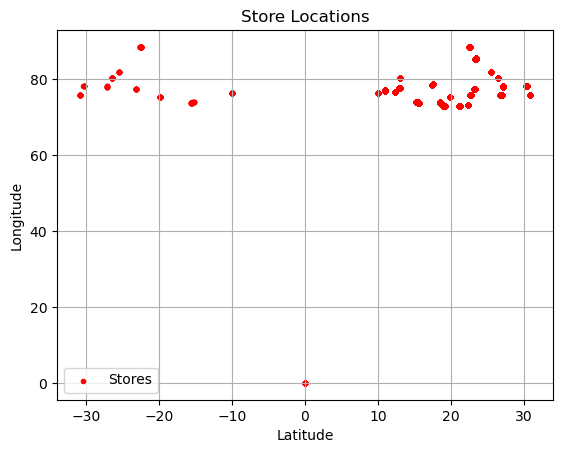

In [29]:
# Plots store locations on a scatter plot using latitude and longitude.
plt.scatter(df_clean['Store_Latitude'], df_clean['Store_Longitude'], c='red', marker='.', label='Stores')

# Labels and title
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Store Locations')
plt.legend()
    
# Show the plot
plt.grid(True)
plt.show()



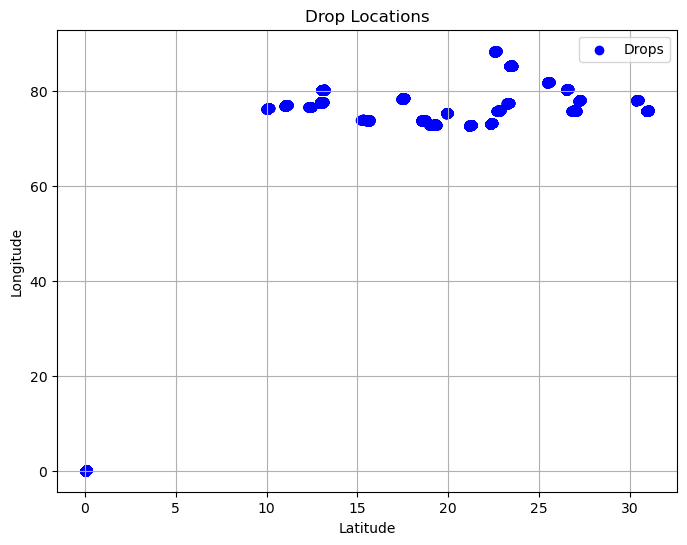

In [30]:
# # Plots drop locations on a scatter plot using latitude and longitude.
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['Drop_Latitude'], df_clean['Drop_Longitude'], c='blue', marker='o', label='Drops')
# Labels and title
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Drop Locations')
plt.legend()
    
# Show the plot
plt.grid(True)
plt.show()


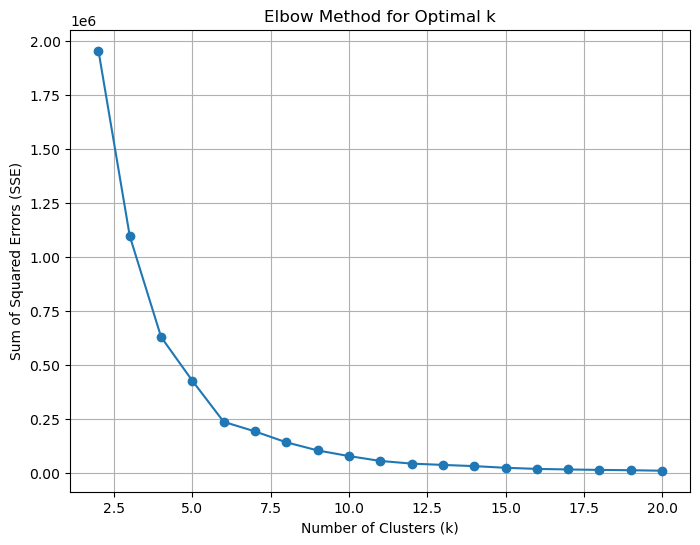

In [31]:
# Clusters store locations using K-Means.

def plot_elbow_method(data, max_clusters=20):
    """
    Uses the Elbow Method to find the optimal number of clusters in K-Means.
    """
    sse = []  # Store Sum of Squared Errors for different cluster sizes
    cluster_range = range(2, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=2)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center

    # Plot the Elbow Curve
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, sse, marker='o', linestyle='-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

#Drop_Latitude	Drop_Longitude
data = df_clean[['Store_Latitude','Store_Longitude']]
plot_elbow_method(data, max_clusters=20)

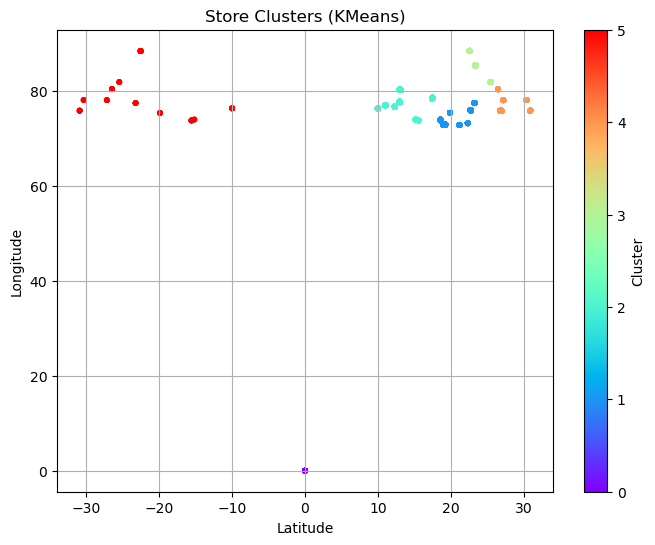

In [32]:
# Beyond k = 6 or more, the SSE reduction is minimal, indicating diminishing returns.
# choose k=6 for stores
store_kmeans = KMeans(n_clusters=6, random_state=42, n_init=2)
df_clean['Store_Cluster']=store_kmeans.fit_predict(df_clean[['Store_Latitude', 'Store_Longitude']])

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter( df_clean['Store_Latitude'],df_clean['Store_Longitude'], c=df_clean['Store_Cluster'], cmap='rainbow', marker='.')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Store Clusters (KMeans)')
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


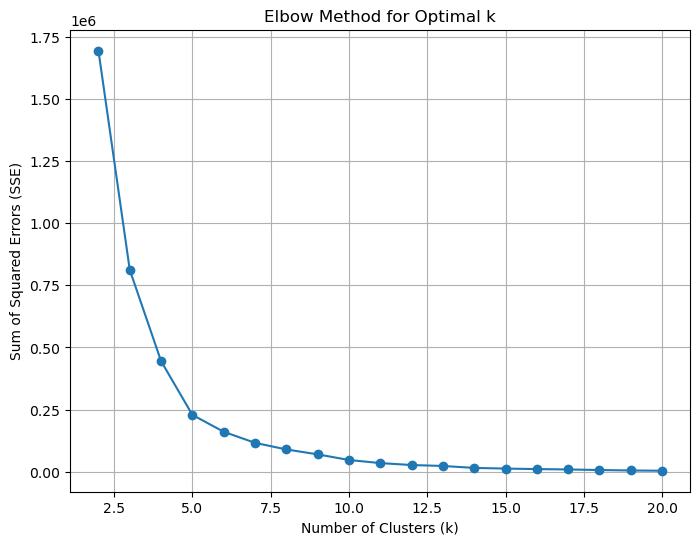

In [33]:
plot_elbow_method(df_clean[['Drop_Latitude', 'Drop_Longitude']], max_clusters=20)

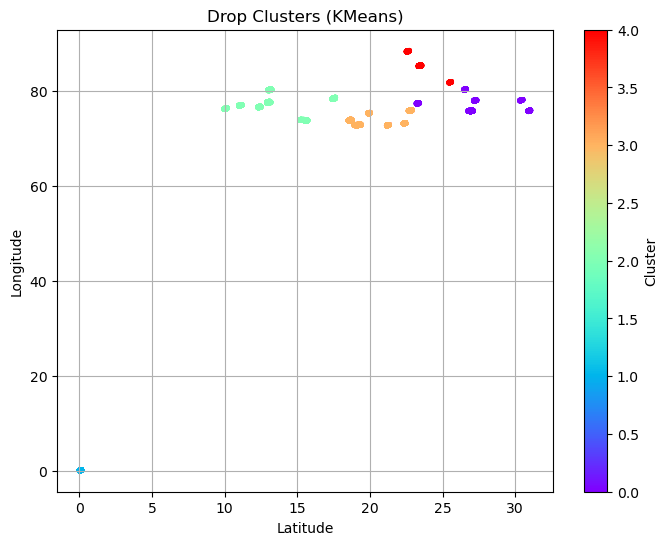

In [34]:
# After k = 4 or k = 5, the SSE continues to decrease but at a much slower rate.
drop_kmeans = KMeans(n_clusters=5, random_state=42, n_init=2)
df_clean['Drop_Cluster']=drop_kmeans.fit_predict(df_clean[['Drop_Latitude', 'Drop_Longitude']])

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter( df_clean['Drop_Latitude'],df_clean['Drop_Longitude'], c=df_clean['Drop_Cluster'], cmap='rainbow', marker='.')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Drop Clusters (KMeans)')
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

In [35]:
# check the pair of the store-drop is less than 6*5
# Group by (Store_Cluster, Drop_Cluster) and count occurrences
pair_counts = df_clean.groupby(['Store_Cluster', 'Drop_Cluster']).size().reset_index(name='Count')

# Sort by frequency
pair_counts = pair_counts.sort_values(by='Count', ascending=False)

# Display the result
print(pair_counts)

   Store_Cluster  Drop_Cluster  Count
3              2             2  16242
2              1             3  14125
5              4             0   5559
4              3             4   3624
0              0             1   3495
1              1             0    447
6              5             0     63
7              5             2     38
9              5             4     36
8              5             3     19


In [36]:
# creat a varibale by pair the store_cluster and drop_cluster
df_clean['Pair'] = df_clean['Store_Cluster'].astype(str) + '_' + df_clean['Drop_Cluster'].astype(str)
    

## Circularly encode Order_Time and Pickup_time



In [38]:
def encode_time_circular(df, time_col='Time',sin_col='sin_time',cos_col='cos_time'):
    """
    Circularly encodes a time column (HH:MM) into two features: sin_time and cos_time.
    """
    # Convert time to total minutes of the day
    df['Minutes'] = pd.to_datetime(df[time_col], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(df[time_col], format='%H:%M:%S').dt.minute

    # Apply circular encoding
    df[sin_col] = np.sin(2 * np.pi * df['Minutes'] / 1440)
    df[cos_col] = np.cos(2 * np.pi * df['Minutes'] / 1440)

    # Drop the original minute representation
    df.drop(columns=['Minutes'], inplace=True)
    
    return df

# encode Order_time
df_clean = encode_time_circular(df_clean,time_col='Order_Time',sin_col='Order_sin_time',cos_col='Order_cos_time')

# encode Pickup_time
df_clean = encode_time_circular(df_clean,time_col='Pickup_Time',sin_col='Pickup_sin_time',cos_col='Pickup_cos_time')



In [39]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43648 entries, 0 to 43738
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Order_ID           43648 non-null  object        
 1   Agent_Age          43648 non-null  int64         
 2   Agent_Rating       43648 non-null  float64       
 3   Store_Latitude     43648 non-null  float64       
 4   Store_Longitude    43648 non-null  float64       
 5   Drop_Latitude      43648 non-null  float64       
 6   Drop_Longitude     43648 non-null  float64       
 7   Order_Date         43648 non-null  datetime64[ns]
 8   Order_Time         43648 non-null  datetime64[ns]
 9   Pickup_Time        43648 non-null  datetime64[ns]
 10  Weather            43648 non-null  object        
 11  Traffic            43648 non-null  object        
 12  Vehicle            43648 non-null  object        
 13  Area               43648 non-null  object        
 14  Delivery_Ti

## Correlation Analysis (Linear Relationships)

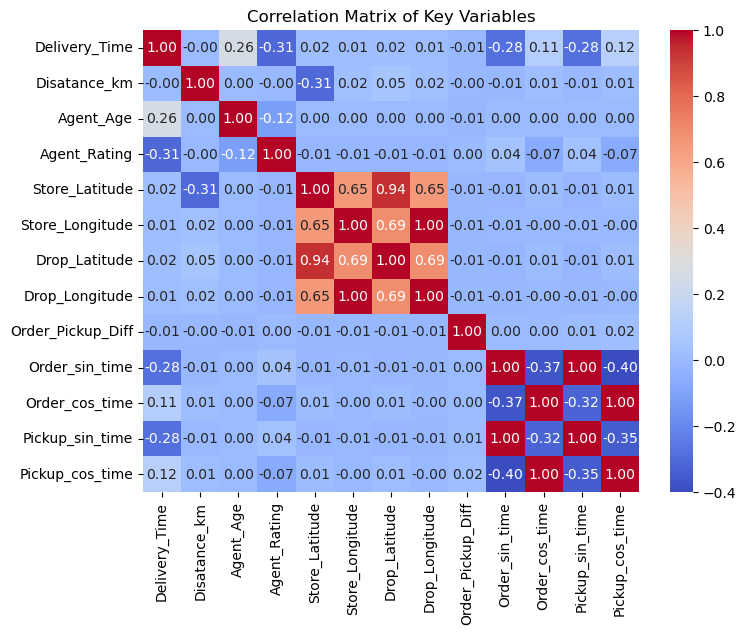

In [41]:
# Select relevant columns for correlation analysis
correlation_columns = [ 'Delivery_Time', 'Disatance_km', 
                       'Agent_Age', 'Agent_Rating', 'Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude','Order_Pickup_Diff','Order_sin_time','Order_cos_time','Pickup_sin_time','Pickup_cos_time']

# Compute the correlation matrix
corr_matrix = df_clean[correlation_columns].corr()

# Visualize with a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.show()

Location-based variables (Store_Latitude, Store_Longitude, Drop_Latitude, Drop_Longitude) seem to have very weak correlations and may not be useful plusing they are used to calculate the distance.
Distance_km may not show strong correlation here, but should be important for modeling delivery time

## Pairwise Scatter Plots (Detecting Nonlinear Relationships)

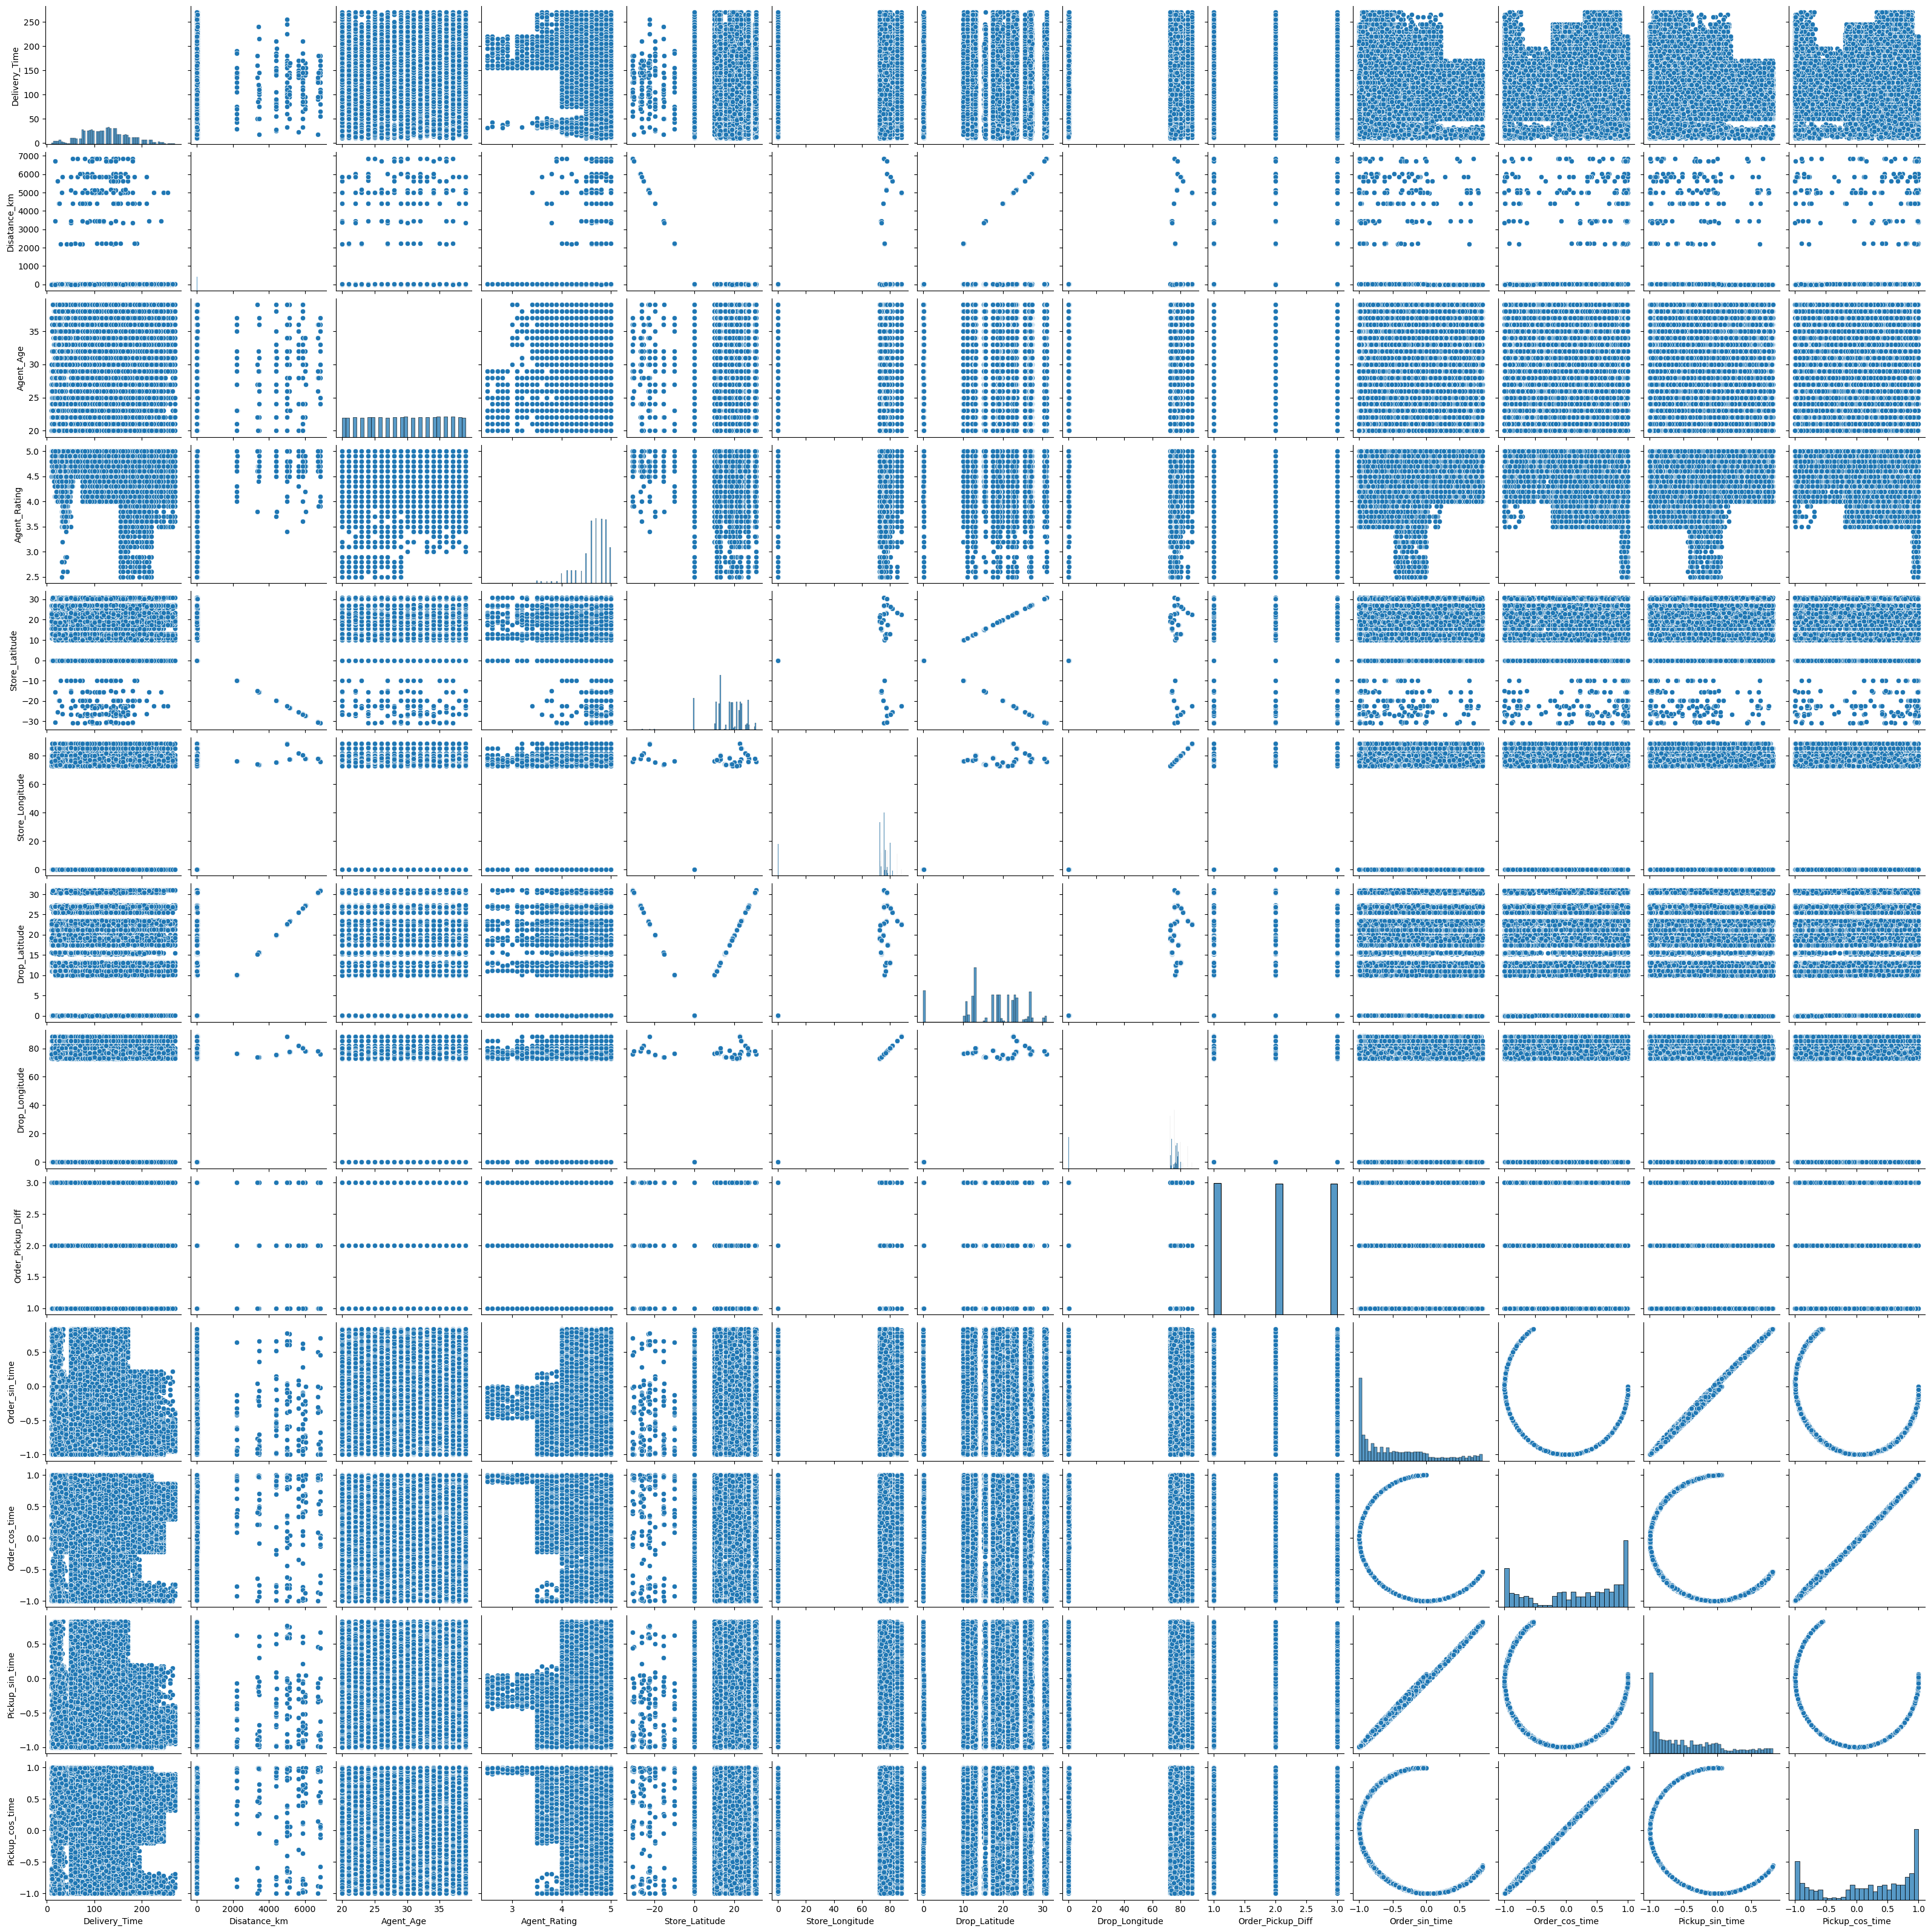

In [44]:
sns.pairplot(df_clean, vars=correlation_columns)
plt.show()


## Impact of Categorical Variables on Delivery Time Boxplots to Compare Different Categories

In [46]:
# Check for unique values for each categorical column
print(df_clean['Agent_Age'].unique())
print(df_clean['Agent_Rating'].unique())
print(df_clean['Weather'].unique())
print(df_clean['Traffic'].unique())
print(df_clean['Vehicle'].unique())
print(df_clean['Area'].unique())
print(df_clean['Category'].unique())

[37 34 23 38 32 22 33 35 36 21 24 29 25 31 27 26 20 28 39 30]
[4.9 4.5 4.4 4.7 4.6 4.8 4.2 4.3 4.  4.1 5.  3.5 3.8 3.9 3.7 2.6 2.5 3.6
 3.1 2.7 3.2 3.3 3.4 2.8 2.9 3. ]
['Sunny' 'Stormy' 'Sandstorms' 'Cloudy' 'Fog' 'Windy']
['High ' 'Jam ' 'Low ' 'Medium ']
['motorcycle ' 'scooter ' 'van']
['Urban ' 'Metropolitian ' 'Semi-Urban ' 'Other']
['Clothing' 'Electronics' 'Sports' 'Cosmetics' 'Toys' 'Snacks' 'Shoes'
 'Apparel' 'Jewelry' 'Outdoors' 'Grocery' 'Books' 'Kitchen' 'Home'
 'Pet Supplies' 'Skincare']


### Traffic vs Delivery_Time

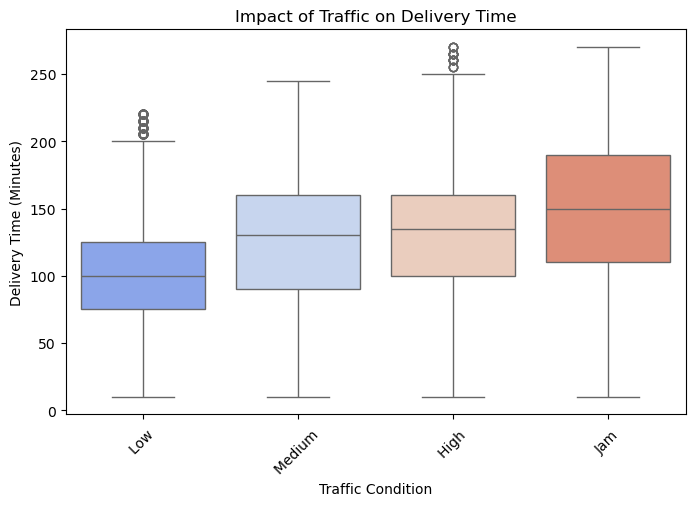

In [48]:
# Plots boxplots of Traffic and Traffic vs. Delivery_Time
# with different colors for different y-axis values and specified Traffic order.

traffic_order = ['Low ', 'Medium ', 'High ', 'Jam ']


plt.figure(figsize=(8, 5))

# Boxplot for Traffic vs Delivery_Time
sns.boxplot(x=df_clean['Traffic'], y=df_clean['Delivery_Time'],order=traffic_order,palette='coolwarm')
plt.title('Impact of Traffic on Delivery Time')
plt.xlabel('Traffic Condition')
plt.ylabel('Delivery Time (Minutes)')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

Obviously, Delivery_Time is influenced by traffic conditions, as traffic congestion can directly impact the time required for delivery. However, the time taken for picking up the goods (Order_Pickup_Diff) appears to be unrelated to traffic, suggesting that factors such as store processing time or agent efficiency may play a more significant role in this stage.

### Weather vs. Order_Pickup_Diff and Delivery_Time

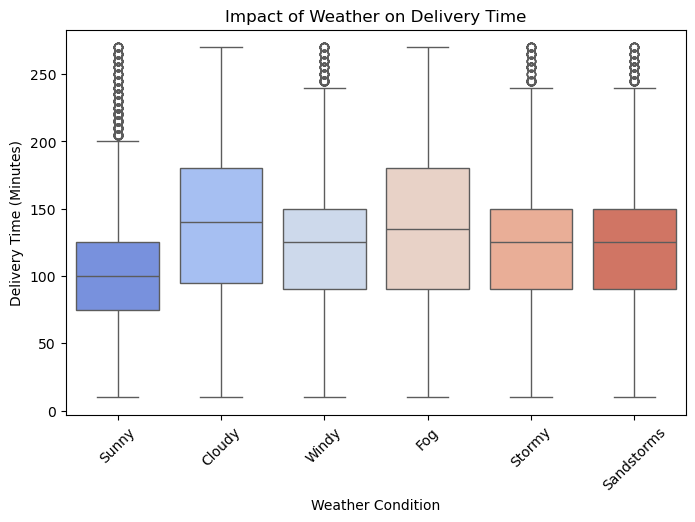

In [50]:
weather_order = ['Sunny','Cloudy','Windy','Fog','Stormy', 'Sandstorms'  ]

plt.figure(figsize=(8, 5))

# Boxplot for Weather vs Delivery_Time
sns.boxplot(x=df_clean['Weather'], y=df_clean['Delivery_Time'],order=weather_order,palette='coolwarm')
plt.title('Impact of Weather on Delivery Time')
plt.xlabel('Weather Condition')
plt.ylabel('Delivery Time (Minutes)')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

Weather has some impact on delivery time


### Vehicle vs. Order_Pickup_Diff and Delivery_Time

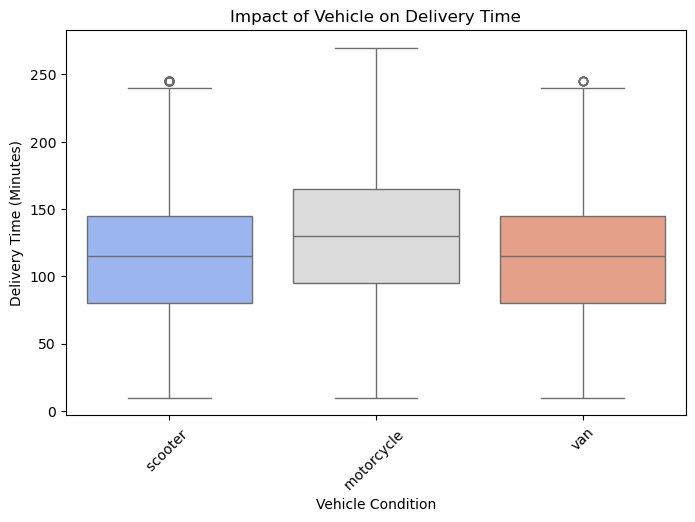

In [52]:
vehicle_order = ['scooter ','motorcycle ' , 'van' ]


plt.figure(figsize=(8, 5))

# Boxplot for Vehicle vs Delivery_Time
sns.boxplot(x=df_clean['Vehicle'], y=df_clean['Delivery_Time'],order=vehicle_order,palette='coolwarm')
plt.title('Impact of Vehicle on Delivery Time')
plt.xlabel('Vehicle Condition')
plt.ylabel('Delivery Time (Minutes)')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

### Area vs. Order_Pickup_Diff and Delivery_Time

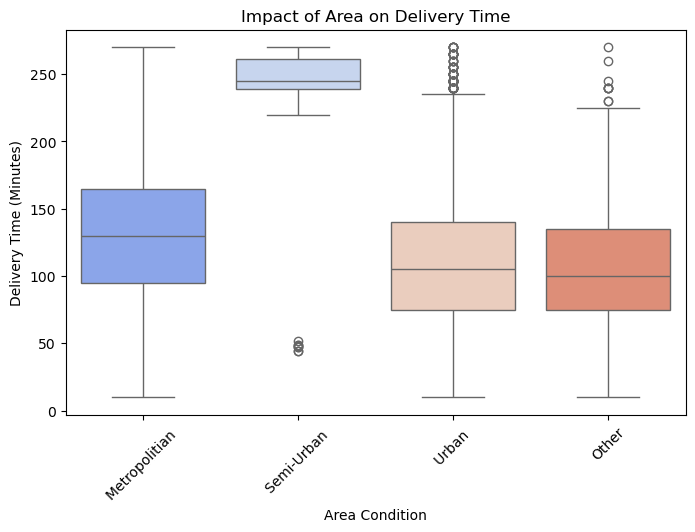

In [54]:

area_order = [ 'Metropolitian ', 'Semi-Urban ', 'Urban ','Other']


plt.figure(figsize=(8, 5))

# Boxplot for Area vs Delivery_Time
sns.boxplot(x=df_clean['Area'], y=df_clean['Delivery_Time'],order=area_order,palette='coolwarm')
plt.title('Impact of Area on Delivery Time')
plt.xlabel('Area Condition')
plt.ylabel('Delivery Time (Minutes)')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

Area impact on the delivery time.

### Category vs. Order_Pickup_Diff and Delivery_Time

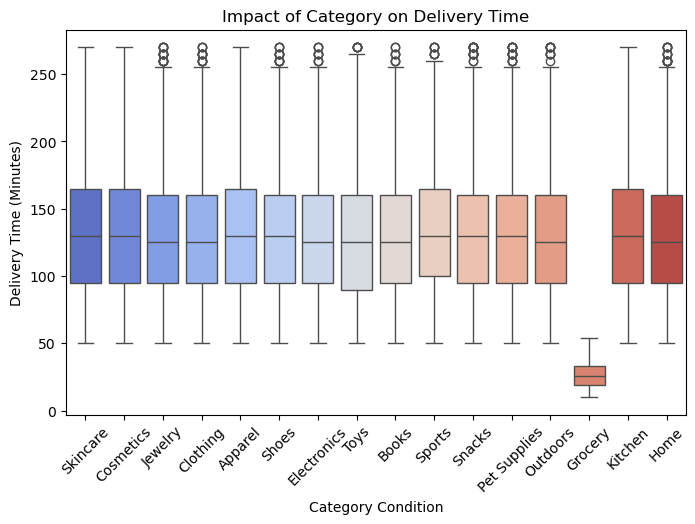

In [56]:
category_order = [
    'Skincare',  # Very light (creams, lotions)
    'Cosmetics',  # Small bottles, makeup
    'Jewelry',  # Lightweight accessories
    'Clothing',  # Light garments (shirts, dresses)
    'Apparel',  # Similar to clothing
    'Shoes',  # Heavier than clothing but still light
    'Electronics',  # Phones, small gadgets
    'Toys',  # Varies, but mostly light
    'Books',  # Paperweight, moderate
    'Sports',  # Rackets, balls, medium weight
    'Snacks',  # Packaged food, varies
    'Pet Supplies',  # Toys, accessories, moderate weight
    'Outdoors',  # Camping gear, tools
    'Grocery',  # Food, can include heavy items
    'Kitchen',  # Appliances, cookware, heavier
    'Home'  # Furniture, large household items
]

plt.figure(figsize=(8, 5))

# Boxplot for Category vs Delivery_Time
sns.boxplot(x=df_clean['Category'], y=df_clean['Delivery_Time'],order=category_order,palette='coolwarm')
plt.title('Impact of Category on Delivery Time')
plt.xlabel('Category Condition')
plt.ylabel('Delivery Time (Minutes)')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

Weather has some impact on delivery time

## Store_Drop pair vs Order_Pickup_Diff and Delivery_Time

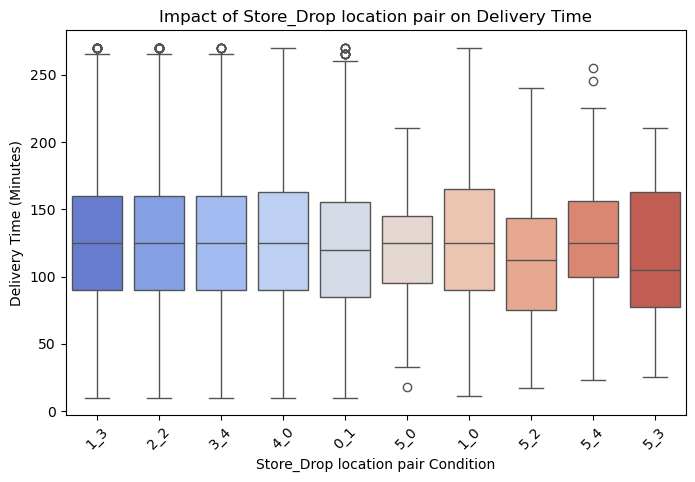

In [58]:
# Set figure size
plt.figure(figsize=(8, 5))

# Boxplot for Pair vs Delivery_Time
sns.boxplot(x=df_clean['Pair'], y=df_clean['Delivery_Time'],palette='coolwarm')
plt.title('Impact of Store_Drop location pair on Delivery Time')
plt.xlabel('Store_Drop location pair Condition')
plt.ylabel('Delivery Time (Minutes)')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

Store_Drop pair have some impact both on Order_Pickup time and Delivery_Time

### Hoilday vs. Order_Pickup_Diff and Delivery_Time

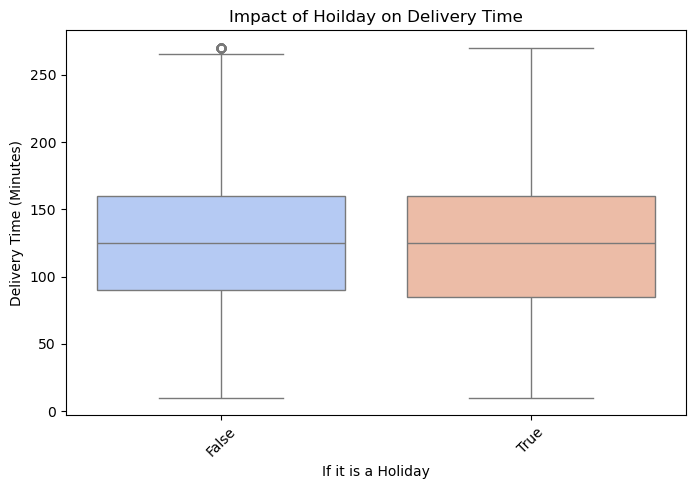

In [60]:
# Set figure size

plt.figure(figsize=(8, 5))

# Boxplot for Hoilday vs Delivery_Time
sns.boxplot(x=df_clean['Is_Holiday'], y=df_clean['Delivery_Time'],palette='coolwarm')
plt.title('Impact of Hoilday on Delivery Time')
plt.xlabel('If it is a Holiday')
plt.ylabel('Delivery Time (Minutes)')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

## One-Hot encoding Categorical variables

Data columns (total 28 columns):
| #  | Column             | Non-Null Count  | Dtype            | Processing          |
|----|--------------------|----------------|----------------|--------------------|
| 0  | Order_ID          | 43648 non-null  | object         | None               |
| 1  | Agent_Age         | 43648 non-null  | int64          | Copy               |
| 2  | Agent_Rating      | 43648 non-null  | float64        | Copy               |
| 3  | Store_Latitude    | 43648 non-null  | float64        | None               |
| 4  | Store_Longitude   | 43648 non-null  | float64        | None               |
| 5  | Drop_Latitude     | 43648 non-null  | float64        | None               |
| 6  | Drop_Longitude    | 43648 non-null  | float64        | None               |
| 7  | Order_Date        | 43648 non-null  | datetime64[ns] | None               |
| 8  | Order_Time        | 43648 non-null  | datetime64[ns] | None               |
| 9  | Pickup_Time       | 43648 non-null  | datetime64[ns] | None               |
| 10 | Weather           | 43648 non-null  | object         | One-Hot encoding   |
| 11 | Traffic           | 43648 non-null  | object         | None               |
| 12 | Vehicle           | 43648 non-null  | object         | One-Hot encoding   |
| 13 | Area              | 43648 non-null  | object         | One-Hot encoding   |
| 14 | Delivery_Time     | 43648 non-null  | int64          | Copy               |
| 15 | Category          | 43648 non-null  | object         | One-Hot encoding   |
| 16 | Distance_km       | 43648 non-null  | float64        | Copy               |
| 17 | Traffic_code      | 43648 non-null  | int64          | Copy               |
| 18 | Weekday           | 43648 non-null  | int32          | Copy               |
| 19 | Is_Holiday        | 43648 non-null  | bool           | Copy               |
| 20 | Order_Pickup_Diff | 43648 non-null  | int64          | Copy               |
| 21 | Store_Cluster     | 43648 non-null  | int32          | None               |
| 22 | Drop_Cluster      | 43648 non-null  | int32          | None               |
| 23 | Pair              | 43648 non-null  | object         | One-Hot encoding   |
| 24 | Order_sin_time    | 43648 non-null  | float64        | Copy               |
| 25 | Order_cos_time    | 43648 non-null  | float64        | Copy               |
| 26 | Pickup_sin_time   | 43648 non-null  | float64        | Copy               |
| 27 | Pickup_cos_time   | 43648 non-null  | float64        | Copy               |


In [62]:
# One-Hot encoding

df_feature=df_clean[['Disatance_km','Order_sin_time',
       'Order_cos_time', 'Pickup_sin_time', 'Pickup_cos_time','Agent_Age', 'Agent_Rating','Order_Pickup_Diff','Traffic_code', 'Weekday',
       'Is_Holiday','Weather', 'Vehicle', 'Area','Category','Pair']]# 
df_feature = pd.get_dummies(df_feature, columns=['Weather'])
df_feature = pd.get_dummies(df_feature, columns=['Vehicle'])
df_feature = pd.get_dummies(df_feature, columns=['Area'])
df_feature = pd.get_dummies(df_feature, columns=['Category'])
df_feature = pd.get_dummies(df_feature, columns=['Pair'], prefix='StoreDrop')
df_feature['Delivery_Time']=df_clean['Delivery_Time']
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43648 entries, 0 to 43738
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Disatance_km           43648 non-null  float64
 1   Order_sin_time         43648 non-null  float64
 2   Order_cos_time         43648 non-null  float64
 3   Pickup_sin_time        43648 non-null  float64
 4   Pickup_cos_time        43648 non-null  float64
 5   Agent_Age              43648 non-null  int64  
 6   Agent_Rating           43648 non-null  float64
 7   Order_Pickup_Diff      43648 non-null  int64  
 8   Traffic_code           43648 non-null  int64  
 9   Weekday                43648 non-null  int32  
 10  Is_Holiday             43648 non-null  bool   
 11  Weather_Cloudy         43648 non-null  bool   
 12  Weather_Fog            43648 non-null  bool   
 13  Weather_Sandstorms     43648 non-null  bool   
 14  Weather_Stormy         43648 non-null  bool   
 15  Weather

#  Predict Delivery Time 

Since the dataset primarily consists of categorical variables, with the exception of Distance_km, Order_sin_time, Order_cos_time, Pickup_sin_time, and Pickup_cos_time, a Random Forest model is chosen for predicting Delivery_Time. Random Forest is well-suited for handling categorical features and capturing complex relationships in the data while being robust to noise and missing values.

In [64]:


# Load Data (Assuming df_clean is already loaded)
# Define features and target
X = df_feature.drop(columns=['Delivery_Time'])
y = df_feature['Delivery_Time']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize continuous features
scaler = StandardScaler()
continuous_features = ['Disatance_km']
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])


# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [10, 30, 50],
    'min_samples_split': [ 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,  # Inner loop cross-validation
    scoring='r2',
    n_jobs=-1,
    verbose=2
)
# Train on training set only
grid_search.fit(X_train, y_train)


# Best parameters from cross-validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train final model with best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=5,
                      n_estimators=300, random_state=42)

In [65]:
# Predict and evaluate
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display results
results = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}
print("Final Model Performance:")
print(results)

Final Model Performance:
{'MSE': 530.4983236618856, 'RMSE': 23.032549221957296, 'MAE': 17.996927981529748, 'R²': 0.8046395339311322}
